In [32]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import pandas as pd
from typing import Callable


pd.options.display.max_columns = 21
pd.options.display.float_format = '{:.2f}'.format
save_images = False

### Paramètres

Dans un premier temps on considère que les as valent toujours 1  
On considère aussi que le blackjack (As + Bûche) est un état comme les autres et vaut autant qu'un 21 classique

In [33]:
Card = int
Action = int
Policy = Callable[[int, int], Action]

ACE: Card = 1
TWO: Card = 2
THREE: Card = 3
FOUR: Card = 4
FIVE: Card = 5
SIX: Card = 6
SEVEN: Card = 7
EIGHT: Card = 8
NINE: Card = 9
TEN: Card = 10
JACK: Card = 10
QUEEN: Card = 10
KING: Card = 10

card_values: list[Card] = [ACE, TWO, THREE, FOUR, FIVE, SIX, SEVEN, EIGHT, NINE, TEN, JACK, QUEEN, KING]

max_card_value: int = max(card_values)
max_score: int = 21

On ne considère aussi que deux actions possibles pour le joueur

In [34]:
HIT: Action = 0 
STAND: Action = 1

actions_str: dict[Action, str] = {
    HIT: 'HIT',
	STAND: 'STAND'
}

On considère aussi un tirage avec remise, on a donc une distribution uniforme des cartes à tout moment

In [35]:
def probaDraw(card: Card) -> float:
	"""
	Probability of hitting a given card
	"""
	return 1 / len(card_values)

### Calcul de la politique optimale du croupier

In [36]:
def probaHit(score: int) -> float:
	"""
	Probability of hitting and not bursting
	"""
	return sum([probaDraw(card) for card in card_values if score + card <= max_score])

def probaHitList(score: int) -> list[int, float]:
	"""
	Compute the score and the probability of hitting for each card that do not burst the score
	"""
	return [(score + card, probaDraw(card)) for card in card_values if score + card <= max_score]

In [37]:
def probaBurst(score: int) -> float:
	"""
	Probability of bursting the score
	"""
	return 1 - probaHit(score)

def probaBurstList(score: int) -> list[int, float]:
	"""
	Compute the score and the probability of bursting for each card that do burst the score
	"""
	return [(score + card, probaDraw(card)) for card in card_values if score + card > max_score]

In [38]:
def getGainMatrixDealerFromPolicy(policy: Policy) -> np.ndarray:
	"""
	Compute the gain matrix for the dealer from a given policy
	"""
	GainMatrix = np.zeros((max_score, max_score))
	for sp in range(max_score):
		for sd in range(max_score-1, -1, -1):
			dealer_action = policy(sp+1, sd+1)
			if dealer_action == HIT:
				for new_sd, proba in probaHitList(sd+1):
					GainMatrix[sp, sd] += proba * GainMatrix[sp, new_sd-1]
				GainMatrix[sp, sd] -= probaBurst(sd+1)
			elif dealer_action == STAND:
				GainMatrix[sp, sd] = 1 if sp < sd else -1 if sp > sd else 0
			else:
				raise Exception("Invalid dealer action")
	return GainMatrix

On peut définir maintenant différentes politiques et calculer leur gains moyens  

On implémente la stratégie classique "stand on 17"  

En considérant que le joueur est seul face au croupier on peut alors intuitivement définir la politique optimale du croupier de la façon suivante:  
+  Si le croupier gagne déjà au score: STAND
+  Si le croupier est perdant au score: HIT
+  Si il y a égalité: Déterminer le meilleur choix entre HIT et faire une partie nulle

In [39]:
def standOn17(sp: int, sd: int) -> Action:
	"""
	Dealer policy: stand on 17
	"""
	return STAND if sd >= 17 else HIT

In [40]:
def dealerOptimalPolicy(sp: int, sd: int) -> Action:
	"""
	Optimal policy
	"""
	if sp > max_score:
		return STAND
	if sp == sd:
		return HIT if probaHit(sp) >= probaBurst(sp) else STAND
	return HIT if sp > sd else STAND

In [41]:
def policyMatrixFromPolicy(policy: Policy) -> np.ndarray:
	"""
	Compute the policy matrix from a given policy
	"""
	PolicyMatrix = np.zeros((max_score, max_score))
	for sp in range(max_score):
		for sd in range(max_score):
			PolicyMatrix[sp, sd] = policy(sp+1, sd+1)
	return PolicyMatrix

In [42]:
def printGainMatrix(gainMatrix: np.ndarray):
	"""
	Print the gain matrix
	"""
	df = pd.DataFrame(gainMatrix, index=range(1, len(gainMatrix)+1), columns=range(1, len(gainMatrix[0])+1))
	return df

In [43]:
dealerGain17 = getGainMatrixDealerFromPolicy(standOn17)
printGainMatrix(dealerGain17)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
1,0.40,0.25,0.22,0.18,0.14,0.10,0.43,0.47,0.51,0.54,0.58,0.03,-0.04,-0.11,-0.17,-0.23,1.00,1.00,1.00,1.00,1.00
2,0.40,0.25,0.22,0.18,0.14,0.10,0.43,0.47,0.51,0.54,0.58,0.03,-0.04,-0.11,-0.17,-0.23,1.00,1.00,1.00,1.00,1.00
3,0.40,0.25,0.22,0.18,0.14,0.10,0.43,0.47,0.51,0.54,0.58,0.03,-0.04,-0.11,-0.17,-0.23,1.00,1.00,1.00,1.00,1.00
4,0.40,0.25,0.22,0.18,0.14,0.10,0.43,0.47,0.51,0.54,0.58,0.03,-0.04,-0.11,-0.17,-0.23,1.00,1.00,1.00,1.00,1.00
5,0.40,0.25,0.22,0.18,0.14,0.10,0.43,0.47,0.51,0.54,0.58,0.03,-0.04,-0.11,-0.17,-0.23,1.00,1.00,1.00,1.00,1.00
6,0.40,0.25,0.22,0.18,0.14,0.10,0.43,0.47,0.51,0.54,0.58,0.03,-0.04,-0.11,-0.17,-0.23,1.00,1.00,1.00,1.00,1.00
7,0.40,0.25,0.22,0.18,0.14,0.10,0.43,0.47,0.51,0.54,0.58,0.03,-0.04,-0.11,-0.17,-0.23,1.00,1.00,1.00,1.00,1.00
8,0.40,0.25,0.22,0.18,0.14,0.10,0.43,0.47,0.51,0.54,0.58,0.03,-0.04,-0.11,-0.17,-0.23,1.00,1.00,1.00,1.00,1.00
9,0.40,0.25,0.22,0.18,0.14,0.10,0.43,0.47,0.51,0.54,0.58,0.03,-0.04,-0.11,-0.17,-0.23,1.00,1.00,1.00,1.00,1.00
10,0.40,0.25,0.22,0.18,0.14,0.10,0.43,0.47,0.51,0.54,0.58,0.03,-0.04,-0.11,-0.17,-0.23,1.00,1.00,1.00,1.00,1.00


In [44]:
dealerOptimalGain = getGainMatrixDealerFromPolicy(dealerOptimalPolicy)
printGainMatrix(dealerOptimalGain)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
4,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
5,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
6,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
7,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
8,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
10,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [45]:
def plot_single_policy_matrix_dealer(policy_matrix, title=None, ax=None, cmap=None, norm=None, plot_legend=True):
    unique_values = sorted(set(val for val in np.unique(policy_matrix)))
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 10))
    else:
        fig = ax.figure 
    if cmap is None:
        cmap = plt.cm.get_cmap("coolwarm", len(unique_values))
    if norm is None:
        norm = mcolors.BoundaryNorm(boundaries=np.linspace(min(unique_values) - 0.5, max(unique_values) + 0.5, len(unique_values) + 1), ncolors=len(unique_values))
    im = ax.imshow(policy_matrix, cmap=cmap, norm=norm, aspect="auto", origin="lower")
    if title:
        ax.set_title(title, fontsize=14, pad=20)
    
    ax.set_xticks(np.arange(0, policy_matrix.shape[1]))
    ax.set_yticks(np.arange(0, policy_matrix.shape[0]))
    ax.set_xticklabels(np.arange(1, policy_matrix.shape[1] + 1, 1))
    ax.set_yticklabels(np.arange(1, policy_matrix.shape[0] + 1, 1))
    ax.set_xlabel("Dealer Score", fontsize=12, labelpad=15)
    ax.set_ylabel("Player Score", fontsize=12, labelpad=15)
    ax.set_xticks(np.arange(-.5, policy_matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, policy_matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)
    
    if plot_legend:
        actions_str = [f"Action {int(val)}" for val in unique_values]
        legend_patches = [Patch(color=cmap(norm(val)), label=actions_str[int(val)]) for val in unique_values]
        ax.legend(handles=legend_patches, loc="upper center", ncol=len(unique_values), 
                  frameon=False, fontsize=12, handlelength=2, handletextpad=1, bbox_to_anchor=(0.5, 1.1))
        fig.subplots_adjust(top=0.85)
    
    return im


def plot_policy_matrices_dealer(policyMatrices, titles=None, save=False):
    titles = titles if titles is not None else [f"Policy Grid {i + 1}" for i in range(len(policyMatrices))]
    num_matrices = len(policyMatrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(8* num_matrices, 10))
    if num_matrices == 1:
        axes = [axes]
    
    all_unique_values = sorted(set(val for matrix in policyMatrices for val in np.unique(matrix)))
    cmap = plt.cm.get_cmap("coolwarm", len(all_unique_values))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(all_unique_values) + 1) - 0.5, ncolors=len(all_unique_values))
    
    for i, (policy, title) in enumerate(zip(policyMatrices, titles)):
        plot_single_policy_matrix_dealer(policy, title=title, ax=axes[i], cmap=cmap, norm=norm, plot_legend=False)
    
    legend_patches = [Patch(color=cmap(i / (len(all_unique_values) - 1)), label=actions_str[int(val)])
                      for i, val in enumerate(all_unique_values)]
    fig.legend(handles=legend_patches, loc="upper center", ncol=len(all_unique_values),
               frameon=False, fontsize=14, handlelength=2, handletextpad=1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save:
        plt.savefig("../images/q1_policies_dealer_plot.png")
    plt.show()


In [46]:
def plot_single_gain_matrix_dealer(policy_matrix, title=None, ax=None, cmap=None, norm=None, plot_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 10))
    else:
        fig = ax.figure 

    if cmap is None:
        cmap = plt.cm.cividis
    if norm is None:
        norm = mcolors.Normalize(vmin=0, vmax=1)
    
    im = ax.imshow(policy_matrix, cmap=cmap, norm=norm, aspect="auto", origin="lower")
    
    if title:
        ax.set_title(title, fontsize=14, pad=20)
    
    ax.set_xticks(np.arange(0, policy_matrix.shape[1]))
    ax.set_yticks(np.arange(0, policy_matrix.shape[0]))
    ax.set_xticklabels(np.arange(1, policy_matrix.shape[1] + 1, 1))
    ax.set_yticklabels(np.arange(1, policy_matrix.shape[0] + 1, 1))
    ax.set_xlabel("Dealer Score", fontsize=12, labelpad=15)
    ax.set_ylabel("Player Score", fontsize=12, labelpad=15)
    ax.set_xticks(np.arange(-.5, policy_matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, policy_matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)
    
    if plot_legend:
        cbar = fig.colorbar(im, ax=ax, orientation="vertical")
        cbar.set_label("Gain", fontsize=12)
        cbar.set_ticks(np.linspace(-1, 1, 11)) 
    return im


def plot_gain_matrices_dealer(policyMatrices, titles=None, save=False):
    titles = titles if titles is not None else [f"Policy Grid {i + 1}" for i in range(len(policyMatrices))]
    num_matrices = len(policyMatrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(8 * num_matrices, 10))
    if num_matrices == 1:
        axes = [axes]
    
    cmap = plt.cm.inferno 
    norm = mcolors.Normalize(vmin=-1, vmax=1) 

    for i, (policy, title) in enumerate(zip(policyMatrices, titles)):
        plot_single_gain_matrix_dealer(policy, title=title, ax=axes[i], cmap=cmap, norm=norm, plot_legend=(i == num_matrices - 1))
    
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
    if save:
        plt.savefig("../images/q1_gain_dealer_plot.png")
    plt.show()

/tmp/ipykernel_13045/440244572.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("coolwarm", len(all_unique_values))


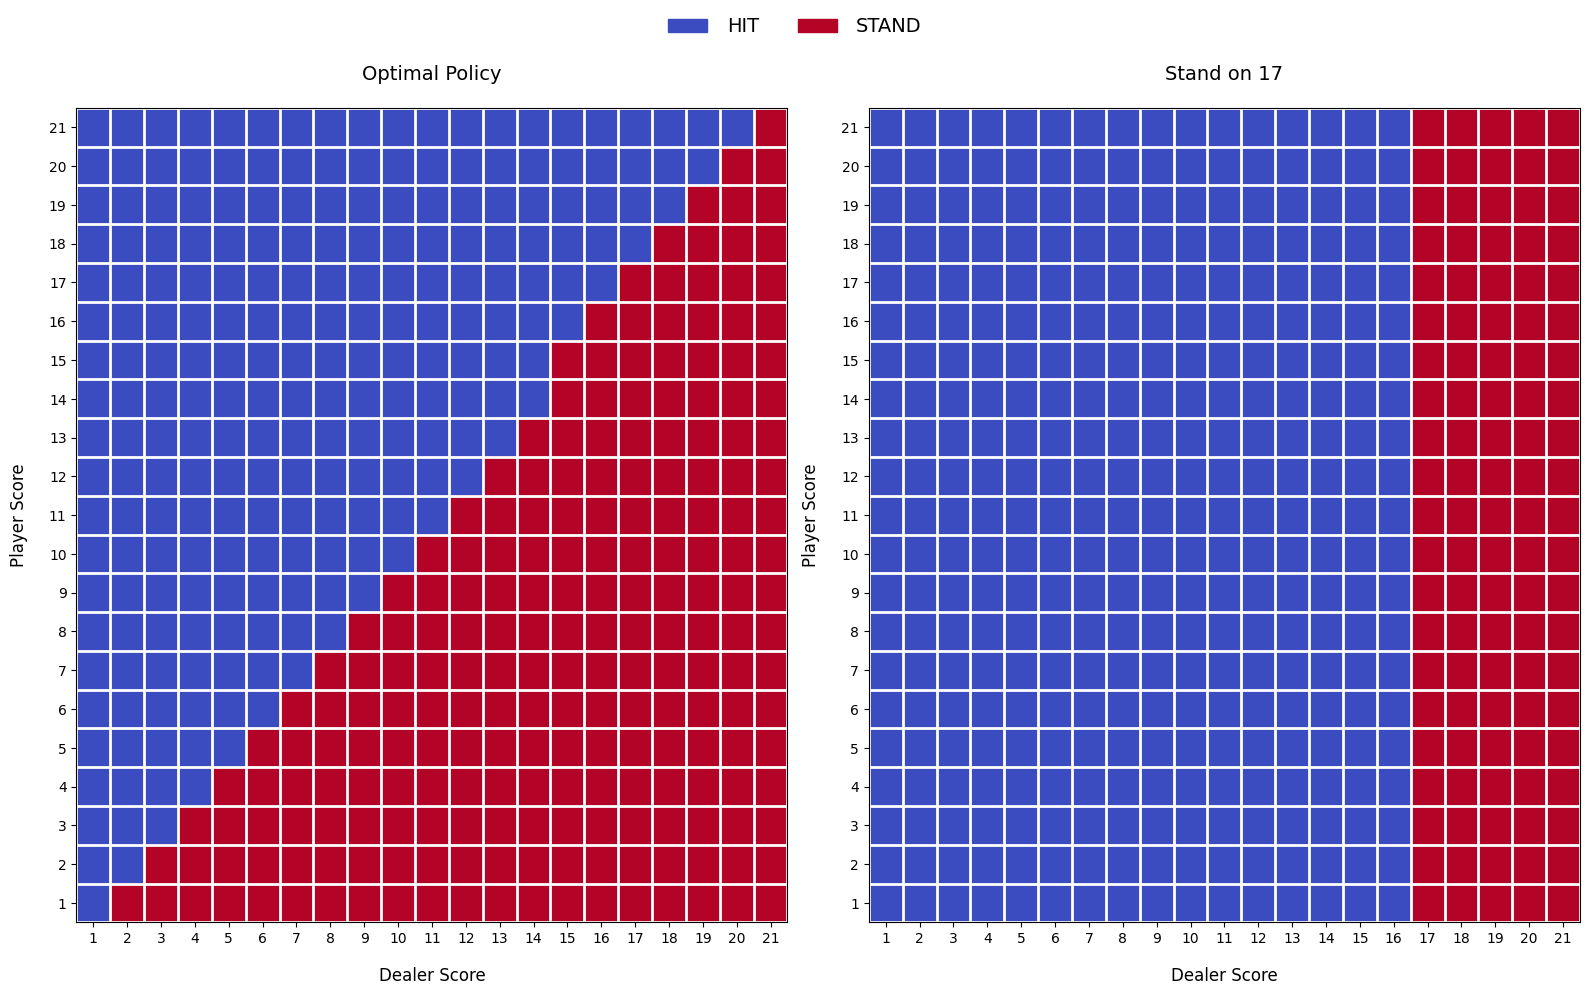

In [47]:
dealerPolicyMatrixOptimal = policyMatrixFromPolicy(dealerOptimalPolicy)
dealerPolicyMatrix17 = policyMatrixFromPolicy(standOn17)
plot_policy_matrices_dealer([dealerPolicyMatrixOptimal, dealerPolicyMatrix17], ["Optimal Policy", "Stand on 17"], save=save_images)

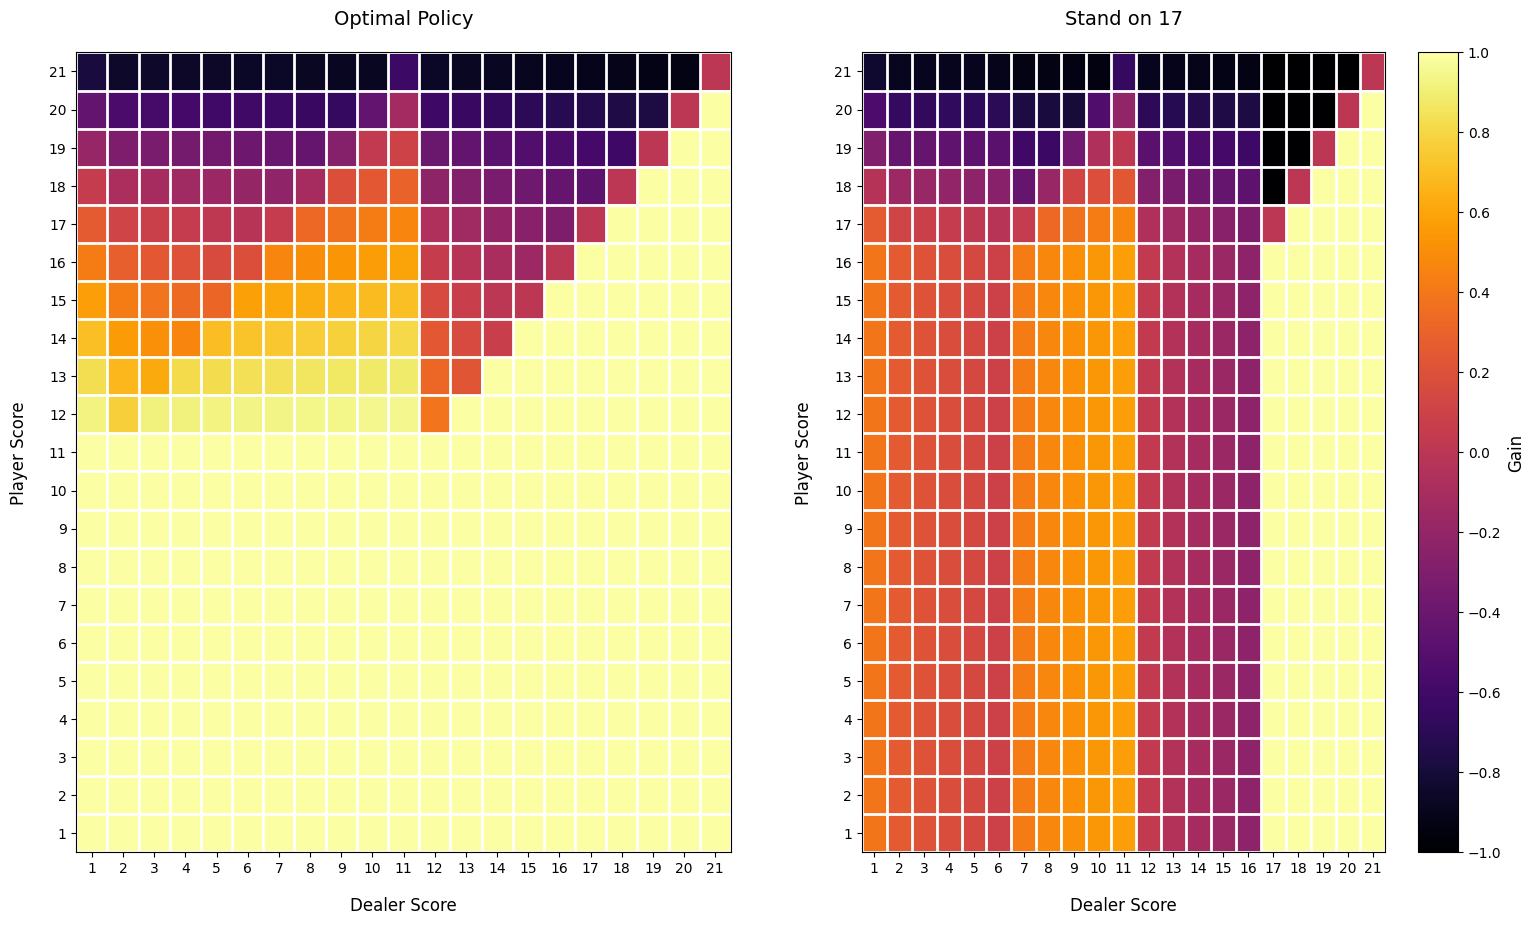

In [48]:
plot_gain_matrices_dealer([dealerOptimalGain, dealerGain17], ["Optimal Policy", "Stand on 17"], save=save_images)

Avec ces gains on peut maintenant calculer la politique optimale du joueur face à cet adversaire

In [49]:
def getGainMatrixPlayerOptimalPolicy(dealerGainMatrix: np.ndarray) -> np.ndarray:
	"""
	Compute the gain matrix for the player using the optimal policy
	"""
	GainMatrix = np.zeros((max_score, max_card_value))
	for sp in range(max_score-1, -1, -1):
		for sd in range(max_card_value-1, -1, -1):
			hit_score = 0
			for new_sp, proba in probaHitList(sp+1):
				hit_score += proba * GainMatrix[new_sp-1, sd]
			hit_score -= probaBurst(sp+1)
   
			stand_score = - dealerGainMatrix[sp, sd]
			GainMatrix[sp, sd] = max(hit_score, stand_score)
	return GainMatrix

In [50]:
playerOptimalGain = getGainMatrixPlayerOptimalPolicy(dealerOptimalGain)
printGainMatrix(playerOptimalGain)

,1,2,3,4,5,6,7,8,9,10
1,-0.12,-0.03,-0.01,0.01,0.03,0.03,-0.01,-0.06,-0.12,-0.20
2,-0.24,-0.15,-0.13,-0.11,-0.09,-0.09,-0.13,-0.18,-0.24,-0.32
3,-0.26,-0.18,-0.16,-0.14,-0.12,-0.12,-0.15,-0.20,-0.26,-0.34
4,-0.28,-0.20,-0.18,-0.16,-0.14,-0.15,-0.18,-0.23,-0.29,-0.36
5,-0.31,-0.23,-0.20,-0.17,-0.15,-0.17,-0.21,-0.25,-0.31,-0.38
6,-0.30,-0.20,-0.17,-0.15,-0.12,-0.13,-0.23,-0.28,-0.33,-0.40
7,-0.26,-0.16,-0.13,-0.10,-0.08,-0.08,-0.13,-0.25,-0.30,-0.37
8,-0.20,-0.10,-0.07,-0.05,-0.02,-0.02,-0.05,-0.13,-0.26,-0.32
9,-0.13,-0.02,0.00,0.02,0.05,0.05,0.02,-0.02,-0.12,-0.26
10,-0.03,0.07,0.09,0.12,0.14,0.14,0.11,0.07,0.02,-0.11


In [51]:
playerOptimalGain17 = getGainMatrixPlayerOptimalPolicy(dealerGain17)
printGainMatrix(playerOptimalGain17)

,1,2,3,4,5,6,7,8,9,10
1,-0.07,0.05,0.08,0.10,0.13,0.16,0.07,0.01,-0.07,-0.16
2,-0.19,-0.08,-0.05,-0.02,0.01,0.05,-0.05,-0.12,-0.20,-0.28
3,-0.21,-0.09,-0.06,-0.03,0.00,0.04,-0.08,-0.14,-0.22,-0.30
4,-0.23,-0.11,-0.08,-0.04,-0.01,0.03,-0.11,-0.17,-0.24,-0.32
5,-0.24,-0.12,-0.09,-0.05,-0.02,0.02,-0.14,-0.20,-0.27,-0.34
6,-0.25,-0.13,-0.09,-0.06,-0.03,0.01,-0.17,-0.22,-0.29,-0.37
7,-0.22,-0.10,-0.07,-0.03,0.00,0.03,-0.08,-0.21,-0.27,-0.34
8,-0.14,-0.02,0.01,0.04,0.07,0.10,0.06,-0.07,-0.21,-0.28
9,-0.06,0.07,0.09,0.12,0.15,0.18,0.13,0.08,-0.06,-0.21
10,0.04,0.16,0.18,0.21,0.23,0.26,0.21,0.16,0.09,-0.05


On peut à présent calculer le gain global du joueur

In [52]:
def computePlayerGlobalGain(playerGainMatrix: np.ndarray) -> float:
	"""
	Compute the global gain for the player
	"""
	gain = 0
	for card1_player in card_values:
		for card2_player in card_values:
			for card_dealer in card_values:
				player_score = card1_player + card2_player
				gain += playerGainMatrix[player_score-1, card_dealer-1] * probaDraw(card1_player) * probaDraw(card2_player) * probaDraw(card_dealer)
	return gain

In [53]:
print(f"Mean gain for the player with the optimal policy against optimal dealer: {computePlayerGlobalGain(playerOptimalGain):.3f}")
print(f"Mean gain for the player with the optimal policy against dealer stand on 17: {computePlayerGlobalGain(playerOptimalGain17):.3f}")

Mean gain for the player with the optimal policy against optimal dealer: -0.130
Mean gain for the player with the optimal policy against dealer stand on 17: -0.057


In [54]:
def getPlayerOptimalPolicyMatrix(playerGainMatrix: np.ndarray) -> Policy:
	"""
	Compute the optimal policy matrix for the player
	"""
	PolicyMatrix = np.zeros((max_score, max_card_value))
	for sp in range(max_score-1, -1, -1):
		for sd in range(max_card_value-1, -1, -1):
			hit_score = 0
			for new_sp, proba in probaHitList(sp+1):
				hit_score += proba * playerGainMatrix[new_sp-1, sd]
			hit_score -= probaBurst(sp+1)
			PolicyMatrix[sp, sd] = HIT if hit_score == playerGainMatrix[sp, sd] else STAND
	return PolicyMatrix
	

In [55]:
playerOptimalPolicyMatrix = getPlayerOptimalPolicyMatrix(playerOptimalGain)
playerOptimalPolicyMatrix17 = getPlayerOptimalPolicyMatrix(playerOptimalGain17)

In [56]:
def plot_single_policy_matrix_player(policy_matrix, title=None, ax=None, cmap=None, norm=None, plot_legend=True):
    unique_values = sorted(set(val for val in np.unique(policy_matrix)))
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 10))
    else:
        fig = ax.figure 
    if cmap is None:
        cmap = plt.cm.get_cmap("coolwarm", len(unique_values))
    if norm is None:
        norm = mcolors.BoundaryNorm(boundaries=np.linspace(min(unique_values) - 0.5, max(unique_values) + 0.5, len(unique_values) + 1), ncolors=len(unique_values))
    im = ax.imshow(policy_matrix, cmap=cmap, norm=norm, aspect="auto", origin="lower")
    if title:
        ax.set_title(title, fontsize=14, pad=20)
    
    ax.set_xticks(np.arange(0, policy_matrix.shape[1]))
    ax.set_yticks(np.arange(0, policy_matrix.shape[0]))
    ax.set_xticklabels(np.arange(1, policy_matrix.shape[1] + 1, 1))
    ax.set_yticklabels(np.arange(1, policy_matrix.shape[0] + 1, 1))
    ax.set_xlabel("Dealer Card Value", fontsize=12, labelpad=15)
    ax.set_ylabel("Player Score", fontsize=12, labelpad=15)
    ax.set_xticks(np.arange(-.5, policy_matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, policy_matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)
    
    if plot_legend:
        actions_str = [f"Action {int(val)}" for val in unique_values]
        legend_patches = [Patch(color=cmap(norm(val)), label=actions_str[int(val)]) for val in unique_values]
        ax.legend(handles=legend_patches, loc="upper center", ncol=len(unique_values), 
                  frameon=False, fontsize=12, handlelength=2, handletextpad=1, bbox_to_anchor=(0.5, 1.1))
        fig.subplots_adjust(top=0.85)
    
    return im


def plot_policy_matrices_player(policyMatrices, titles=None, save=False):
    titles = titles if titles is not None else [f"Policy Grid {i + 1}" for i in range(len(policyMatrices))]
    num_matrices = len(policyMatrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(7 * num_matrices, 10))
    if num_matrices == 1:
        axes = [axes]
    
    all_unique_values = sorted(set(val for matrix in policyMatrices for val in np.unique(matrix)))
    cmap = plt.cm.get_cmap("coolwarm", len(all_unique_values))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(all_unique_values) + 1) - 0.5, ncolors=len(all_unique_values))
    
    for i, (policy, title) in enumerate(zip(policyMatrices, titles)):
        plot_single_policy_matrix_player(policy, title=title, ax=axes[i], cmap=cmap, norm=norm, plot_legend=False)
    
    legend_patches = [Patch(color=cmap(i / (len(all_unique_values) - 1)), label=actions_str[int(val)])
                      for i, val in enumerate(all_unique_values)]
    fig.legend(handles=legend_patches, loc="upper center", ncol=len(all_unique_values),
               frameon=False, fontsize=14, handlelength=2, handletextpad=1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save:
        plt.savefig("../images/q1_policies_plot.png")
    plt.show()


In [57]:
def plot_single_gain_matrix_player(policy_matrix, title=None, ax=None, cmap=None, norm=None, plot_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 10))
    else:
        fig = ax.figure 

    if cmap is None:
        cmap = plt.cm.cividis
    if norm is None:
        norm = mcolors.Normalize(vmin=0, vmax=1)
    
    im = ax.imshow(policy_matrix, cmap=cmap, norm=norm, aspect="auto", origin="lower")
    
    if title:
        ax.set_title(title, fontsize=14, pad=20)
    
    ax.set_xticks(np.arange(0, policy_matrix.shape[1]))
    ax.set_yticks(np.arange(0, policy_matrix.shape[0]))
    ax.set_xticklabels(np.arange(1, policy_matrix.shape[1] + 1, 1))
    ax.set_yticklabels(np.arange(1, policy_matrix.shape[0] + 1, 1))
    ax.set_xlabel("Dealer Card Value", fontsize=12, labelpad=15)
    ax.set_ylabel("Player Score", fontsize=12, labelpad=15)
    ax.set_xticks(np.arange(-.5, policy_matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, policy_matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)
    
    if plot_legend:
        cbar = fig.colorbar(im, ax=ax, orientation="vertical")
        cbar.set_label("Gain", fontsize=12)
        cbar.set_ticks(np.linspace(-1, 1, 11)) 
    return im


def plot_gain_matrices_player(policyMatrices, titles=None, save=False):
    titles = titles if titles is not None else [f"Policy Grid {i + 1}" for i in range(len(policyMatrices))]
    num_matrices = len(policyMatrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(8 * num_matrices, 10))
    if num_matrices == 1:
        axes = [axes]
    
    cmap = plt.cm.inferno 
    norm = mcolors.Normalize(vmin=-1, vmax=1) 

    for i, (policy, title) in enumerate(zip(policyMatrices, titles)):
        plot_single_gain_matrix_player(policy, title=title, ax=axes[i], cmap=cmap, norm=norm, plot_legend=(i == num_matrices - 1))
    
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
    if save:
        plt.savefig("../images/q1_gain_player_plot.png")
    plt.show()

/tmp/ipykernel_13045/2052731583.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("coolwarm", len(all_unique_values))


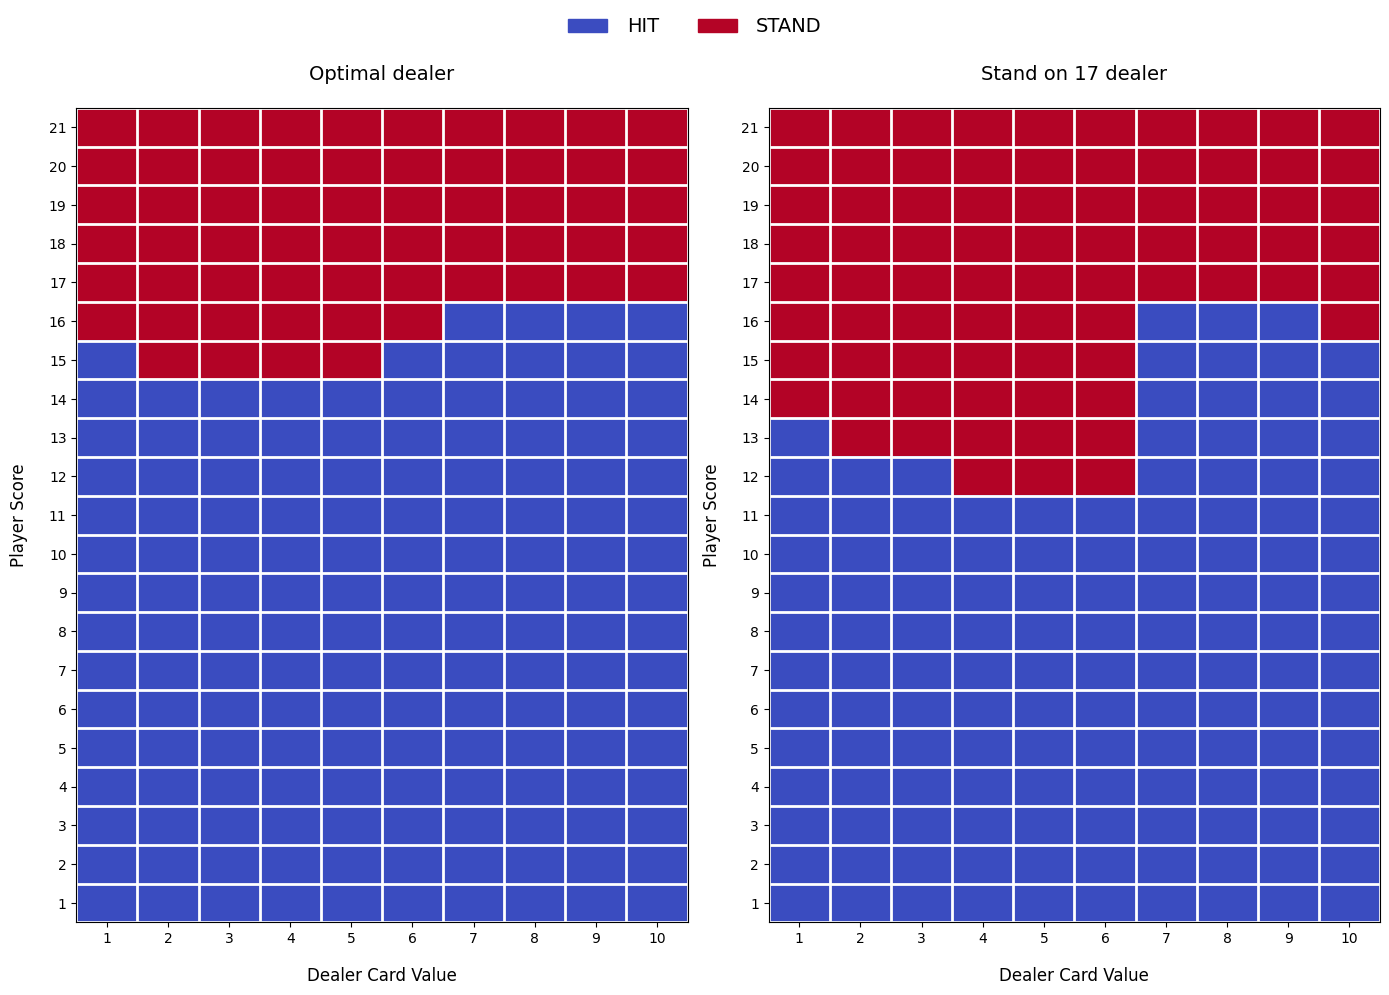

In [58]:
plot_policy_matrices_player([playerOptimalPolicyMatrix, playerOptimalPolicyMatrix17], ["Optimal dealer", "Stand on 17 dealer"], save=save_images)

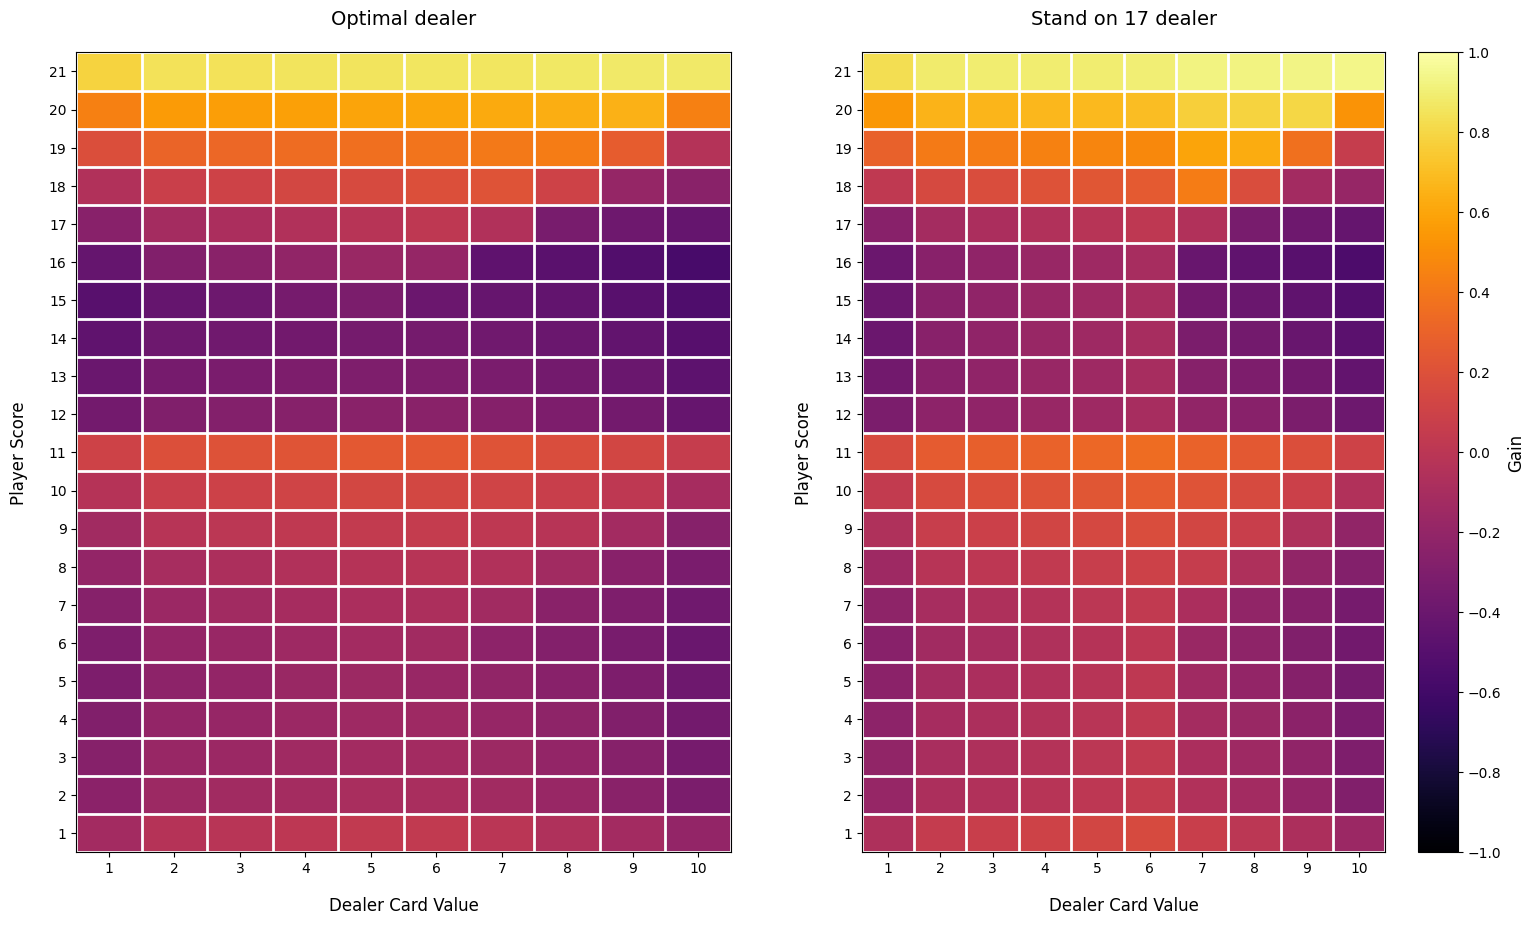

In [59]:
plot_gain_matrices_player([playerOptimalGain, playerOptimalGain17], ["Optimal dealer", "Stand on 17 dealer"], save=save_images)

In [60]:
def getPlayerMeanHandValueMatrix(playerPolicyMatrix, burstEqZero=False):
    MeanHand = np.zeros((21,10))
    for sp in range(max_score-1, -1, -1):
        for sd in range(max_card_value-1, -1, -1):
            if playerPolicyMatrix[sp, sd] == HIT:
                for new_sp, proba_sp in probaHitList(sp+1):
                    MeanHand[sp, sd] += proba_sp * MeanHand[new_sp-1, sd]
                for new_sp, proba_sp in probaBurstList(sp+1):
                    MeanHand[sp, sd] += 0 if burstEqZero else proba_sp * new_sp
            elif playerPolicyMatrix[sp, sd] == STAND:
                MeanHand[sp, sd] = sp
            else:
                raise NotImplementedError
    return MeanHand

In [61]:
def getPlayerMeanHandValue(playerPolicyMatrix, burstEqZero=False) -> float:
	mean_hand_value = 0
	meanHandValueMatrix = getPlayerMeanHandValueMatrix(playerPolicyMatrix, burstEqZero)
	for card1_player in card_values:
		for card2_player in card_values:
			for card_dealer in card_values:
				mean_hand_value += meanHandValueMatrix[card1_player + card2_player -1, card_dealer-1] * probaDraw(card1_player) * probaDraw(card2_player) * probaDraw(card_dealer)
	return mean_hand_value

In [62]:
print(f"Mean hand value for the player with the optimal policy against optimal dealer: {getPlayerMeanHandValue(playerOptimalPolicyMatrix):.3f}")
print(f"Mean hand value for the player with the optimal policy against dealer stand on 17: {getPlayerMeanHandValue(playerOptimalPolicyMatrix17):.3f}")

Mean hand value for the player with the optimal policy against optimal dealer: 18.930
Mean hand value for the player with the optimal policy against dealer stand on 17: 17.490
